# Ride-Hailing Data Analysis - Data Preparation and Preprocessing

We'll begin by loading the rideshare trip data from the City of Chicago's Open Data Portal (https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2018-2022-/m6dm-c72p/about_data). This dataset spans trips taken between November 2018 and December 2022.

After loading the data, we'll assess its quality and perform any necessary cleaning steps. This will ensure the data is in a usable format for analysis and improve the interpretability of our results. The data source itself provides further details on the sampling methodology and attribute explanations, which can be helpful for understanding the data's construction.

# Table of Contents
* [1. Importing libraries and datasets](#chapter1)
* [2. Data Preparation and Preprocessing](#chapter2)
    * [2.1. Data Cleaning](#section2_1)
    * [2.2. Feature Extraction](#section2_2)
* [3. Summary and References](#chapter3)

## 1. Importing libraries and datasets<a id='chapter1'></a>

In [28]:
import numpy as np #Handling mathematical concepts (matrices,...)
import pandas as pd #Handling dataframe in Python
from sklearn.impute import KNNImputer #Interpolate missing numerical values
from datetime import datetime #Handling datetime data
import matplotlib.pyplot as plt #Data visualization
import geopy.distance #Calculating distance between GPS points
from tqdm import tqdm #Observe loop progress
from scipy.spatial import KDTree #Improve loop efficiency

In [2]:
rides = pd.read_csv('Datasets\Transportation_Network_Providers_-_Trips__2018_-_2022__20240510.csv')
print(rides.shape) # Print the number of records and attributes in the dataset
pd.set_option('display.max_columns', None) #Show every columns
rides.head() #Print the first few records of the dataset

C:\Users\Hello\AppData\Local\Temp\ipykernel_13188\3500517183.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  rides = pd.read_csv('Datasets\Transportation_Network_Providers_-_Trips__2018_-_2022__20240510.csv')


(3281752, 21)


,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,33e6599ec8d0aee4d4b781c714b28367e4824578,11/07/2020 06:00:00 PM,11/07/2020 06:00:00 PM,612.0,2.1,1.703124e+10,1.703183e+10,24.0,28.0,10.0,0.0,1.23,11.23,False,1.0,41.899590,-87.674719,POINT (-87.6747191345 41.8995897957),41.885281,-87.657233,POINT (-87.6572331997 41.8852813201)
1,33e65ae63fcbb9c5f1838e1a78e00acb1334b0bc,01/16/2021 09:30:00 PM,01/16/2021 10:15:00 PM,2485.0,26.1,NaN,NaN,1.0,NaN,30.0,0.0,3.13,33.13,False,1.0,42.009623,-87.670167,POINT (-87.6701668569 42.0096228806),NaN,NaN,NaN
2,33e65cb62781db2929780e223b96a2b6a6803ec0,12/07/2020 10:15:00 PM,12/07/2020 10:45:00 PM,1189.0,14.9,NaN,NaN,7.0,71.0,17.5,0.0,3.10,20.60,False,1.0,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.744205,-87.656306,POINT (-87.6563059862 41.7442051463)
3,33e65d9da0847fa6f1c4fc16e00a1cccf9a7b75c,10/03/2020 01:00:00 PM,10/03/2020 01:15:00 PM,954.0,2.6,1.703184e+10,1.703106e+10,8.0,6.0,12.5,0.0,1.23,13.73,False,1.0,41.904935,-87.649907,POINT (-87.6499072264 41.9049353016),41.936310,-87.651563,POINT (-87.6515625922 41.9363101308)
4,33e65f9d2ff996e7ec18ce4dbf08d2815474bb6e,12/06/2020 08:15:00 AM,12/06/2020 08:30:00 AM,472.0,2.1,1.703108e+10,1.703183e+10,8.0,28.0,7.5,0.0,3.10,10.60,False,1.0,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.879067,-87.657005,POINT (-87.657005027 41.8790669938)


The dataset goes beyond just geographical coordinates for pickup and dropoff locations. It also includes the corresponding census tract for each trip. This allows us to explore whether demographics at the census tract level influence tipping behavior. The demographic data used in this analysis was collected independently from a source listed in the references.

In [3]:
#Import the demographic datasets on census tracts in Chicago
census_tracts = pd.read_excel('Datasets\census_tracts_dataset.xlsx')
census_tracts.head()

,ID,Total Population,Number of female,Share Of Female,Share of People Over 65,Median Age,Household
0,Census Tract 101; Cook County; Illinois,4284.0,2053.0,0.479225,0.128618,43.1,"2,942"
1,Census Tract 102.01; Cook County; Illinois,8210.0,4128.0,0.502801,0.090012,32.1,"3,280"
2,Census Tract 102.02; Cook County; Illinois,2865.0,1598.0,0.557766,0.134380,39.5,"1,318"
3,Census Tract 103; Cook County; Illinois,6237.0,3087.0,0.494949,0.000243,48.2,"3,320"
4,Census Tract 104; Cook County; Illinois,4473.0,2294.0,0.512855,0.077800,30.1,"2,397"


Tipping behavior might also be influenced by weather. To account for this, we'll include weather data for Chicago on the days listed in the dataset. I also collected the data from another distinct source listed in the reference.

In [4]:
chicago_weather = pd.read_excel('Datasets\weather-chicago.xlsx')
chicago_weather.head()

,Date,Average Temperature (°F),Average Humidity (%),Average Wind Speed (mph),Average Pressure (in),Total Precipitation (in)
0,2018-01-01,-2.7,63.4,10.5,30.0,0.0
1,2018-01-02,-0.8,69.4,11.6,29.8,0.0
2,2018-01-03,14.2,68.0,12.6,29.4,0.0
3,2018-01-04,6.2,63.1,11.5,29.6,0.0
4,2018-01-05,5.4,61.5,10.5,29.7,0.0


- Data on Chicago trips: https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2018-2022-/m6dm-c72p/about_data
- Demographical data of census tracts: https://data.census.gov/table/ACSDP5Y2022.DP05q=Population%20Total&g=050XX00US17031$1400000
- Chicago Weather data: https://www.wunderground.com/history/monthly/us/il/chicago/KMDW/date/2020-6
- Data Mining: The Textbook, Charu.C.Aggarwal

## 2.Data Preparation and Preprocessing <a id='chapter2'></a>

### 2.1. Data Cleaning <a id='section2_1'></a>

In [5]:
#Check for info and data types of transportation dataset's attributes
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3281752 entries, 0 to 3281751
Data columns (total 21 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip ID                     object 
 1   Trip Start Timestamp        object 
 2   Trip End Timestamp          object 
 3   Trip Seconds                float64
 4   Trip Miles                  float64
 5   Pickup Census Tract         float64
 6   Dropoff Census Tract        float64
 7   Pickup Community Area       float64
 8   Dropoff Community Area      float64
 9   Fare                        float64
 10  Tip                         float64
 11  Additional Charges          float64
 12  Trip Total                  float64
 13  Shared Trip Authorized      object 
 14  Trips Pooled                float64
 15  Pickup Centroid Latitude    float64
 16  Pickup Centroid Longitude   object 
 17  Pickup Centroid Location    object 
 18  Dropoff Centroid Latitude   float64
 19  Dropoff Centroid Long

In [6]:
#Count the number of null values
rides.isna().sum()

Trip ID                             0
Trip Start Timestamp                4
Trip End Timestamp                  4
Trip Seconds                      386
Trip Miles                          5
Pickup Census Tract           2008828
Dropoff Census Tract          2014333
Pickup Community Area          277678
Dropoff Community Area         303262
Fare                              728
Tip                               728
Additional Charges                728
Trip Total                        728
Shared Trip Authorized              4
Trips Pooled                        4
Pickup Centroid Latitude       275198
Pickup Centroid Longitude      275198
Pickup Centroid Location       275199
Dropoff Centroid Latitude      300701
Dropoff Centroid Longitude     300701
Dropoff Centroid Location      300701
dtype: int64

As part of the data preprocessing steps, we will remove entries missing census tract data for pickups or dropoffs. This missing information is essential for our planned merge with demographic data. This cleaning step reduces the initial dataset size by approximately two-thirds. And in fact, this is also acceptable if we are only considering the likelihood of tipping in Chicago. Since as we can read in the dataset description, these attributes are empty if the location is outside of Chicago. Because these are values that we can not numerically interpolate, it would be best if we remove them.

In [7]:
rides = rides.dropna(subset=['Pickup Census Tract', 'Dropoff Census Tract']) #Remove records which has null values in census tract's attributes
print(rides.shape)
rides.isna().sum()

(1214329, 21)


Trip ID                           0
Trip Start Timestamp              0
Trip End Timestamp                0
Trip Seconds                    212
Trip Miles                        0
Pickup Census Tract               0
Dropoff Census Tract              0
Pickup Community Area         12593
Dropoff Community Area        15678
Fare                            141
Tip                             141
Additional Charges              141
Trip Total                      141
Shared Trip Authorized            0
Trips Pooled                      0
Pickup Centroid Latitude      10410
Pickup Centroid Longitude     10410
Pickup Centroid Location      10411
Dropoff Centroid Latitude     13320
Dropoff Centroid Longitude    13320
Dropoff Centroid Location     13320
dtype: int64

To calculate the distance to the nearest public transport stop for each trip, we require complete geographical coordinates for both pickup and drop-off locations. Unfortunately, this means excluding records with missing coordinates from our analysis. However, the number of records with missing coordinates represents a relatively small portion of the overall dataset.

In [8]:
#Remove records which has null values in geospatial attributes
rides = rides.dropna(subset=['Pickup Centroid Latitude','Pickup Centroid Longitude','Pickup Centroid Location'
                            ,'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid Location']) 
print(rides.shape)
rides.isna().sum()

(1190600, 21)


Trip ID                          0
Trip Start Timestamp             0
Trip End Timestamp               0
Trip Seconds                   209
Trip Miles                       0
Pickup Census Tract              0
Dropoff Census Tract             0
Pickup Community Area         2156
Dropoff Community Area        2332
Fare                           127
Tip                            127
Additional Charges             127
Trip Total                     127
Shared Trip Authorized           0
Trips Pooled                     0
Pickup Centroid Latitude         0
Pickup Centroid Longitude        0
Pickup Centroid Location         0
Dropoff Centroid Latitude        0
Dropoff Centroid Longitude       0
Dropoff Centroid Location        0
dtype: int64

We clean the data to be able to figure out a classification model on whether a trip will be tipped or not. Because of this, we would like to drop the records that fail to provide us with their tipping information.

In [9]:
#Remove records which has null values in geospatial attributes
rides = rides.dropna(subset=['Tip']) 
print(rides.shape)
rides.isna().sum()
rides = rides.reset_index() #reset the index count of rows, else there will be gaps between indexes

(1190473, 21)


Our analysis won't utilize the "pickup community area" and "dropoff community area" attributes. Therefore, records with missing values for these features will be retained. Besides, we remove the __Pickup Centroid Location__ and __Dropoff Centroid Location__ attributes to avoid redundancy, because there are four columns corresponding to them already, and working with the separate columns are systematically easier in the implementation approach of ours.

In [10]:
#Remove the attributes relating to community areas
rides = rides.drop(['Pickup Community Area', 'Dropoff Community Area'], axis=1)
rides.head()

,index,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0,33e6599ec8d0aee4d4b781c714b28367e4824578,11/07/2020 06:00:00 PM,11/07/2020 06:00:00 PM,612.0,2.1,1.703124e+10,1.703183e+10,10.0,0.0,1.23,11.23,False,1.0,41.899590,-87.674719,POINT (-87.6747191345 41.8995897957),41.885281,-87.657233,POINT (-87.6572331997 41.8852813201)
1,3,33e65d9da0847fa6f1c4fc16e00a1cccf9a7b75c,10/03/2020 01:00:00 PM,10/03/2020 01:15:00 PM,954.0,2.6,1.703184e+10,1.703106e+10,12.5,0.0,1.23,13.73,False,1.0,41.904935,-87.649907,POINT (-87.6499072264 41.9049353016),41.936310,-87.651563,POINT (-87.6515625922 41.9363101308)
2,4,33e65f9d2ff996e7ec18ce4dbf08d2815474bb6e,12/06/2020 08:15:00 AM,12/06/2020 08:30:00 AM,472.0,2.1,1.703108e+10,1.703183e+10,7.5,0.0,3.10,10.60,False,1.0,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.879067,-87.657005,POINT (-87.657005027 41.8790669938)
3,7,33e664ac9611b2037bb2de21c7888055354f8eed,10/26/2020 11:00:00 PM,10/26/2020 11:15:00 PM,476.0,2.7,1.703108e+10,1.703108e+10,5.0,0.0,3.10,8.10,False,1.0,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.907492,-87.635760,POINT (-87.6357600901 41.9074919303)
4,8,33e66525d69d2b1f834a2cda090021d2c34664a7,10/29/2020 06:30:00 PM,10/29/2020 06:30:00 PM,424.0,2.6,1.703128e+10,1.703184e+10,10.0,0.0,4.85,14.85,False,1.0,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.878667,-87.671654,POINT (-87.6716536214 41.8786674201)


In [11]:
#Drop redundant attributes on geospatial information because we have other columns for it already
rides = rides.drop(['Pickup Centroid Location', 'Dropoff Centroid Location'], axis=1)
rides.head()

,index,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,0,33e6599ec8d0aee4d4b781c714b28367e4824578,11/07/2020 06:00:00 PM,11/07/2020 06:00:00 PM,612.0,2.1,1.703124e+10,1.703183e+10,10.0,0.0,1.23,11.23,False,1.0,41.899590,-87.674719,41.885281,-87.657233
1,3,33e65d9da0847fa6f1c4fc16e00a1cccf9a7b75c,10/03/2020 01:00:00 PM,10/03/2020 01:15:00 PM,954.0,2.6,1.703184e+10,1.703106e+10,12.5,0.0,1.23,13.73,False,1.0,41.904935,-87.649907,41.936310,-87.651563
2,4,33e65f9d2ff996e7ec18ce4dbf08d2815474bb6e,12/06/2020 08:15:00 AM,12/06/2020 08:30:00 AM,472.0,2.1,1.703108e+10,1.703183e+10,7.5,0.0,3.10,10.60,False,1.0,41.893216,-87.637844,41.879067,-87.657005
3,7,33e664ac9611b2037bb2de21c7888055354f8eed,10/26/2020 11:00:00 PM,10/26/2020 11:15:00 PM,476.0,2.7,1.703108e+10,1.703108e+10,5.0,0.0,3.10,8.10,False,1.0,41.890922,-87.618868,41.907492,-87.635760
4,8,33e66525d69d2b1f834a2cda090021d2c34664a7,10/29/2020 06:30:00 PM,10/29/2020 06:30:00 PM,424.0,2.6,1.703128e+10,1.703184e+10,10.0,0.0,4.85,14.85,False,1.0,41.885300,-87.642808,41.878667,-87.671654


In [12]:
#Check for duplicates
rides.duplicated().sum()

0

The pickup and dropoff census tracts are being considered as numbers in the data frame. We do not want this, we need to turn them into string.

In [13]:
#Convert census tracts attributes to non-numerical
rides['Pickup Census Tract'] = rides['Pickup Census Tract'].apply(lambda x: str(int(x)))
rides['Dropoff Census Tract'] = rides['Dropoff Census Tract'].apply(lambda x: str(int(x)))
rides.head()

,index,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,0,33e6599ec8d0aee4d4b781c714b28367e4824578,11/07/2020 06:00:00 PM,11/07/2020 06:00:00 PM,612.0,2.1,17031242200,17031833000,10.0,0.0,1.23,11.23,False,1.0,41.899590,-87.674719,41.885281,-87.657233
1,3,33e65d9da0847fa6f1c4fc16e00a1cccf9a7b75c,10/03/2020 01:00:00 PM,10/03/2020 01:15:00 PM,954.0,2.6,17031842200,17031063000,12.5,0.0,1.23,13.73,False,1.0,41.904935,-87.649907,41.936310,-87.651563
2,4,33e65f9d2ff996e7ec18ce4dbf08d2815474bb6e,12/06/2020 08:15:00 AM,12/06/2020 08:30:00 AM,472.0,2.1,17031081800,17031833100,7.5,0.0,3.10,10.60,False,1.0,41.893216,-87.637844,41.879067,-87.657005
3,7,33e664ac9611b2037bb2de21c7888055354f8eed,10/26/2020 11:00:00 PM,10/26/2020 11:15:00 PM,476.0,2.7,17031081403,17031080300,5.0,0.0,3.10,8.10,False,1.0,41.890922,-87.618868,41.907492,-87.635760
4,8,33e66525d69d2b1f834a2cda090021d2c34664a7,10/29/2020 06:30:00 PM,10/29/2020 06:30:00 PM,424.0,2.6,17031280100,17031838100,10.0,0.0,4.85,14.85,False,1.0,41.885300,-87.642808,41.878667,-87.671654


Also, we turn the dates from string type to the type of date that we can work with

In [14]:
#Bring the timestamp attributes to a proper date type, for easier interaction and performing comparison later on.
def as_date(date_string):
    format_date = "%m/%d/%Y %I:%M:%S %p" #the format of the date that we are extracting from
    date = datetime.strptime(date_string, format_date)
    return date

print(as_date(rides['Trip Start Timestamp'][0])) #18:00:00 since it is AM
rides['Trip Start Timestamp'] = rides['Trip Start Timestamp'].apply(as_date)
rides['Trip End Timestamp'] = rides['Trip End Timestamp'].apply(as_date)
rides.head()

2020-11-07 18:00:00


,index,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,0,33e6599ec8d0aee4d4b781c714b28367e4824578,2020-11-07 18:00:00,2020-11-07 18:00:00,612.0,2.1,17031242200,17031833000,10.0,0.0,1.23,11.23,False,1.0,41.899590,-87.674719,41.885281,-87.657233
1,3,33e65d9da0847fa6f1c4fc16e00a1cccf9a7b75c,2020-10-03 13:00:00,2020-10-03 13:15:00,954.0,2.6,17031842200,17031063000,12.5,0.0,1.23,13.73,False,1.0,41.904935,-87.649907,41.936310,-87.651563
2,4,33e65f9d2ff996e7ec18ce4dbf08d2815474bb6e,2020-12-06 08:15:00,2020-12-06 08:30:00,472.0,2.1,17031081800,17031833100,7.5,0.0,3.10,10.60,False,1.0,41.893216,-87.637844,41.879067,-87.657005
3,7,33e664ac9611b2037bb2de21c7888055354f8eed,2020-10-26 23:00:00,2020-10-26 23:15:00,476.0,2.7,17031081403,17031080300,5.0,0.0,3.10,8.10,False,1.0,41.890922,-87.618868,41.907492,-87.635760
4,8,33e66525d69d2b1f834a2cda090021d2c34664a7,2020-10-29 18:30:00,2020-10-29 18:30:00,424.0,2.6,17031280100,17031838100,10.0,0.0,4.85,14.85,False,1.0,41.885300,-87.642808,41.878667,-87.671654


The "trip seconds" attribute is crucial for our analysis. But actually, unlike the earlier attributes where missing values had to be removed, with trip seconds, a numerical attribute, we can in fact partly interpolate the missing values basing on similarity in other attributes (trip miles,...). Basing on this belief, we will using the K-Nearest Neighbors imputer from scikit.learn in order to guess the missing values. However, in order to do this, we need to further more handle the other features of the dataset to a valid format.

In [15]:
#Take the numerical attributes of the original dataset to perform the imputation, exclude Tip attribute since we are working to 
#predict the tipping likelihood
rides_with_numerical_attributes = rides[['Trip Seconds', 'Trip Miles', 'Fare', 
                                         'Additional Charges', 'Trip Total', 'Shared Trip Authorized', 'Trips Pooled',
                                        'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude',
                                        'Dropoff Centroid Longitude']]
imputer = KNNImputer(n_neighbors = 5, weights='uniform')
'''
Create an imputer to interpolate the missing values basing on the 5 most similar trips in the dataset, without placing
any weights on trips with higher similarity.
'''

filled_rides = imputer.fit_transform(rides_with_numerical_attributes) #return results in form of numpy arrays

In [16]:
filled_rides

array([[612.        ,   2.1       ,  10.        , ..., -87.67471913,
         41.88528132, -87.6572332 ],
       [954.        ,   2.6       ,  12.5       , ..., -87.64990723,
         41.93631013, -87.65156259],
       [472.        ,   2.1       ,   7.5       , ..., -87.63784421,
         41.87906699, -87.65700503],
       ...,
       [587.        ,   2.3       ,   7.5       , ..., -87.733951  ,
         41.89854936, -87.76060432],
       [701.        ,   5.7       ,  12.5       , ..., -87.65029007,
         41.90278805, -87.62614559],
       [846.        ,   7.3       ,  10.        , ..., -87.68364292,
         41.96456804, -87.77226499]])

In [17]:
trip_seconds = [row[0] for row in filled_rides] #Take the list of trip seconds (interpolated values included)
rides['Filled Trip Seconds'] = trip_seconds
rides = rides.drop(['Trip Seconds'], axis=1)
rides.head()

,index,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Filled Trip Seconds
0,0,33e6599ec8d0aee4d4b781c714b28367e4824578,2020-11-07 18:00:00,2020-11-07 18:00:00,2.1,17031242200,17031833000,10.0,0.0,1.23,11.23,False,1.0,41.899590,-87.674719,41.885281,-87.657233,612.0
1,3,33e65d9da0847fa6f1c4fc16e00a1cccf9a7b75c,2020-10-03 13:00:00,2020-10-03 13:15:00,2.6,17031842200,17031063000,12.5,0.0,1.23,13.73,False,1.0,41.904935,-87.649907,41.936310,-87.651563,954.0
2,4,33e65f9d2ff996e7ec18ce4dbf08d2815474bb6e,2020-12-06 08:15:00,2020-12-06 08:30:00,2.1,17031081800,17031833100,7.5,0.0,3.10,10.60,False,1.0,41.893216,-87.637844,41.879067,-87.657005,472.0
3,7,33e664ac9611b2037bb2de21c7888055354f8eed,2020-10-26 23:00:00,2020-10-26 23:15:00,2.7,17031081403,17031080300,5.0,0.0,3.10,8.10,False,1.0,41.890922,-87.618868,41.907492,-87.635760,476.0
4,8,33e66525d69d2b1f834a2cda090021d2c34664a7,2020-10-29 18:30:00,2020-10-29 18:30:00,2.6,17031280100,17031838100,10.0,0.0,4.85,14.85,False,1.0,41.885300,-87.642808,41.878667,-87.671654,424.0


In [18]:
rides.isna().sum() #And now we are done with handling missing data

index                         0
Trip ID                       0
Trip Start Timestamp          0
Trip End Timestamp            0
Trip Miles                    0
Pickup Census Tract           0
Dropoff Census Tract          0
Fare                          0
Tip                           0
Additional Charges            0
Trip Total                    0
Shared Trip Authorized        0
Trips Pooled                  0
Pickup Centroid Latitude      0
Pickup Centroid Longitude     0
Dropoff Centroid Latitude     0
Dropoff Centroid Longitude    0
Filled Trip Seconds           0
dtype: int64

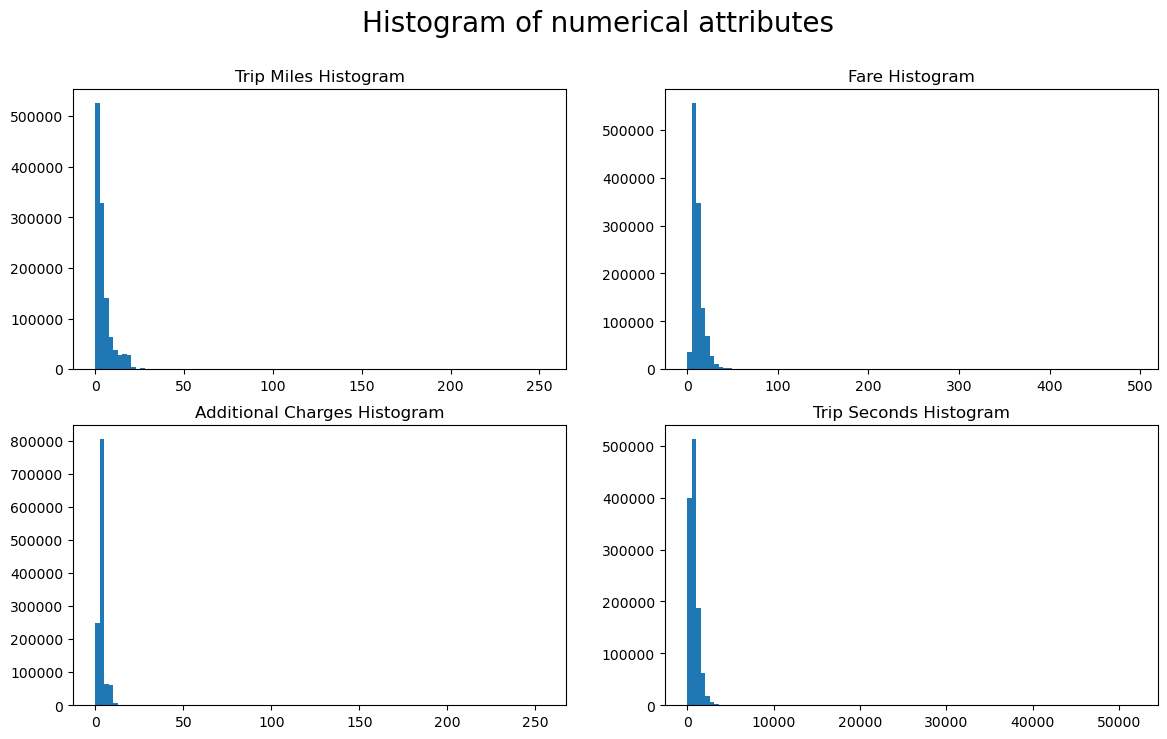

In [19]:
#check for outlier
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

axes[0][0].hist(rides['Trip Miles'], bins = 100)
axes[0][0].set_title('Trip Miles Histogram')
axes[0][1].hist(rides['Fare'], bins = 100)
axes[0][1].set_title('Fare Histogram')
axes[1][0].hist(rides['Additional Charges'], bins = 100)
axes[1][0].set_title('Additional Charges Histogram')
axes[1][1].hist(rides['Filled Trip Seconds'], bins = 100)
axes[1][1].set_title('Trip Seconds Histogram')
fig.suptitle('Histogram of numerical attributes', fontsize=20)
plt.show()

Here, we see that the majority of the trips have low values (short distance, short time, low fare,...), however, there exists special trips causing the distribution to be long-tailed as the visualizations show. However, we would not want to classify these trips as outliers, but rather inspect them more closely (maybe by certain outlier analysis techniques).

### 2.2. Feature Extraction <a id='section2_2'></a>

First we will bring some of the dataset's attributes to the data type which are easier for us to work with. And along the way, we add more attributes in order for deeper analysis for later

In [20]:
#Bring the timestamp attributes to a proper date type, for easier interaction and performing comparison later on.

#Create a function to 
def day_of_week(date):
    # The function returns 0 for Monday and 6 for Sunday
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    return weekdays[date.weekday()]

def month(date):
    return date.month

def part_of_day(date):
    if (date.hour >= 5 and date.hour < 12):
        return 'Morning'
    elif (date.hour >= 12 and date.hour < 17):
        return 'Afternoon'
    elif (date.hour >= 17 and date.hour < 21):
        return 'Evening'
    else:
        return 'Night'
    


In [21]:
#Construct new attributes
rides['Trip Day Of Week'] = rides['Trip Start Timestamp'].apply(day_of_week)
rides['Trip Month'] = rides['Trip Start Timestamp'].apply(month)
rides['Time Of Day'] = rides['Trip Start Timestamp'].apply(part_of_day)

In [22]:
rides.head()

,index,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Filled Trip Seconds,Trip Day Of Week,Trip Month,Time Of Day
0,0,33e6599ec8d0aee4d4b781c714b28367e4824578,2020-11-07 18:00:00,2020-11-07 18:00:00,2.1,17031242200,17031833000,10.0,0.0,1.23,11.23,False,1.0,41.899590,-87.674719,41.885281,-87.657233,612.0,Saturday,11,Evening
1,3,33e65d9da0847fa6f1c4fc16e00a1cccf9a7b75c,2020-10-03 13:00:00,2020-10-03 13:15:00,2.6,17031842200,17031063000,12.5,0.0,1.23,13.73,False,1.0,41.904935,-87.649907,41.936310,-87.651563,954.0,Saturday,10,Afternoon
2,4,33e65f9d2ff996e7ec18ce4dbf08d2815474bb6e,2020-12-06 08:15:00,2020-12-06 08:30:00,2.1,17031081800,17031833100,7.5,0.0,3.10,10.60,False,1.0,41.893216,-87.637844,41.879067,-87.657005,472.0,Sunday,12,Morning
3,7,33e664ac9611b2037bb2de21c7888055354f8eed,2020-10-26 23:00:00,2020-10-26 23:15:00,2.7,17031081403,17031080300,5.0,0.0,3.10,8.10,False,1.0,41.890922,-87.618868,41.907492,-87.635760,476.0,Monday,10,Night
4,8,33e66525d69d2b1f834a2cda090021d2c34664a7,2020-10-29 18:30:00,2020-10-29 18:30:00,2.6,17031280100,17031838100,10.0,0.0,4.85,14.85,False,1.0,41.885300,-87.642808,41.878667,-87.671654,424.0,Thursday,10,Evening


In [23]:
# Create average velocity of the trips
trips_velocity = (rides['Trip Miles']/rides['Filled Trip Seconds']) * 3.6
rides['Average Velocity (miles/h)'] = trips_velocity
rides.head()

,index,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Filled Trip Seconds,Trip Day Of Week,Trip Month,Time Of Day,Average Velocity (miles/h)
0,0,33e6599ec8d0aee4d4b781c714b28367e4824578,2020-11-07 18:00:00,2020-11-07 18:00:00,2.1,17031242200,17031833000,10.0,0.0,1.23,11.23,False,1.0,41.899590,-87.674719,41.885281,-87.657233,612.0,Saturday,11,Evening,0.012353
1,3,33e65d9da0847fa6f1c4fc16e00a1cccf9a7b75c,2020-10-03 13:00:00,2020-10-03 13:15:00,2.6,17031842200,17031063000,12.5,0.0,1.23,13.73,False,1.0,41.904935,-87.649907,41.936310,-87.651563,954.0,Saturday,10,Afternoon,0.009811
2,4,33e65f9d2ff996e7ec18ce4dbf08d2815474bb6e,2020-12-06 08:15:00,2020-12-06 08:30:00,2.1,17031081800,17031833100,7.5,0.0,3.10,10.60,False,1.0,41.893216,-87.637844,41.879067,-87.657005,472.0,Sunday,12,Morning,0.016017
3,7,33e664ac9611b2037bb2de21c7888055354f8eed,2020-10-26 23:00:00,2020-10-26 23:15:00,2.7,17031081403,17031080300,5.0,0.0,3.10,8.10,False,1.0,41.890922,-87.618868,41.907492,-87.635760,476.0,Monday,10,Night,0.020420
4,8,33e66525d69d2b1f834a2cda090021d2c34664a7,2020-10-29 18:30:00,2020-10-29 18:30:00,2.6,17031280100,17031838100,10.0,0.0,4.85,14.85,False,1.0,41.885300,-87.642808,41.878667,-87.671654,424.0,Thursday,10,Evening,0.022075


One interesting factor that might affect the likelihood of tipping is how close the pickup is to the nearest public transport. This could capture if the lack of convenient public transport options influences tipping. In order to extract this feature, I take another dataset, containing data on the locations of bus stops all over Chicago.

In [24]:
bus_stops = pd.read_csv('Datasets\CTA_BusStops.csv')
bus_stops.head()

,X,Y,Name,CITY,CROSS_ST,DIR,Field_1,OWLROUTES,POINT_X,POINT_Y,POS,PUBLIC_NAME,ROUTESSTPG,SHAPE,STATUS,STREET,SYSTEMSTOP
0,-87.846407,41.974865,East River Rd & Berwyn,CHICAGO,BERWYN,NB,East River Rd &amp; Berwyn,NaN,-87.846407,41.974865,NS,East River Rd &amp; Berwyn,81W,Point,In Service,EAST RIVER RD,8590
1,-87.839028,41.983680,Cumberland Blue Line Station,CHICAGO,BLUE LINE STATION,SWB,Cumberland Blue Line Station,NaN,-87.839028,41.983680,TERM,Cumberland Blue Line Station,81W,Point,In Service,CUMBERLAND,14143
2,-87.836433,41.966700,Lawrence & Cumberland,NORRIDGE,CUMBERLAND,WB,Lawrence &amp; Cumberland,NaN,-87.836433,41.966700,NS,Lawrence &amp; Cumberland,81W,Point,In Service,LAWRENCE,9751
3,-87.836837,41.973820,Cumberland & Foster,NORRIDGE,FOSTER,SB,Cumberland &amp; Foster,NaN,-87.836837,41.973820,NS,Cumberland &amp; Foster,81W,Point,In Service,CUMBERLAND,8566
4,-87.836541,41.975598,Cumberland & Berwyn,CHICAGO,BERWYN,NB,Cumberland &amp; Berwyn,NaN,-87.836541,41.975598,NS,Cumberland &amp; Berwyn,81W,Point,In Service,CUMBERLAND,8565


X is the longitude and Y is the latitude, we rename them for easy notice.

In [25]:
bus_stops['Longitude'] = bus_stops['X']
bus_stops['Latitude'] = bus_stops['Y']
bus_stops_locations = bus_stops[['Longitude', 'Latitude']]
bus_stops_locations.head()

,Longitude,Latitude
0,-87.846407,41.974865
1,-87.839028,41.983680
2,-87.836433,41.966700
3,-87.836837,41.973820
4,-87.836541,41.975598


Now, we need a function to calculate the distance of two points on Earth, knowing only their longitude and latitude coordinates. For this, we use the geopy.distance modules. To best improve the efficiency of the loop, we use scipy.spatial modules

In [40]:
pickup_coords = list(zip(rides['Pickup Centroid Longitude'], rides['Pickup Centroid Latitude']))
pickup_coords = [(float(x[0]), float(x[1])) for x in pickup_coords] #During the code, I discovered that some records had their coordinates in string format.
dropoff_coords = list(zip(rides['Dropoff Centroid Longitude'], rides['Dropoff Centroid Latitude']))

bus_stop_coords = list(zip(bus_stops_locations['Longitude'], bus_stops_locations['Latitude']))
bus_stops_tree = KDTree(bus_stop_coords)
nearest_distances = []  # Store distances
for i in tqdm(range(len(rides))):
    _, closest_stop_index = bus_stops_tree.query(pickup_coords[i], k=1)
    
    closest_stop_coord = bus_stop_coords[closest_stop_index]
    dist_to_stop = geopy.distance.distance(pickup_coords[i], closest_stop_coord).miles
    
    nearest_distances.append(dist_to_stop)

100%|██████████████████████████████████████████████████████████████████████| 1190473/1190473 [02:47<00:00, 7118.14it/s]


In [41]:
rides['Distance to nearest Bus Stop (in Miles)'] = nearest_distances
rides.head()

,index,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Filled Trip Seconds,Trip Day Of Week,Trip Month,Time Of Day,Average Velocity (miles/h),Distance to nearest Bus Stop (in Miles)
0,0,33e6599ec8d0aee4d4b781c714b28367e4824578,2020-11-07 18:00:00,2020-11-07 18:00:00,2.1,17031242200,17031833000,10.0,0.0,1.23,11.23,False,1.0,41.899590,-87.674719,41.885281,-87.657233,612.0,Saturday,11,Evening,0.012353,0.162805
1,3,33e65d9da0847fa6f1c4fc16e00a1cccf9a7b75c,2020-10-03 13:00:00,2020-10-03 13:15:00,2.6,17031842200,17031063000,12.5,0.0,1.23,13.73,False,1.0,41.904935,-87.649907,41.936310,-87.651563,954.0,Saturday,10,Afternoon,0.009811,0.094266
2,4,33e65f9d2ff996e7ec18ce4dbf08d2815474bb6e,2020-12-06 08:15:00,2020-12-06 08:30:00,2.1,17031081800,17031833100,7.5,0.0,3.10,10.60,False,1.0,41.893216,-87.637844,41.879067,-87.657005,472.0,Sunday,12,Morning,0.016017,0.058448
3,7,33e664ac9611b2037bb2de21c7888055354f8eed,2020-10-26 23:00:00,2020-10-26 23:15:00,2.7,17031081403,17031080300,5.0,0.0,3.10,8.10,False,1.0,41.890922,-87.618868,41.907492,-87.635760,476.0,Monday,10,Night,0.020420,0.069982
4,8,33e66525d69d2b1f834a2cda090021d2c34664a7,2020-10-29 18:30:00,2020-10-29 18:30:00,2.6,17031280100,17031838100,10.0,0.0,4.85,14.85,False,1.0,41.885300,-87.642808,41.878667,-87.671654,424.0,Thursday,10,Evening,0.022075,0.008717


## 3. Summary and References <a id='chapter3'></a>

Here, we managed to load the necessary datasets and perform decent preprocessing as well as feature engineering work. In the next phase, we will perform certain exploratory data analysis and even feature selection for the future model if possible.

### References:
- Trips dataset: https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2018-2022-/m6dm-c72p/about_data
- Census Tract Characteristics Dataset: https://data.census.gov/table/ACSDP5Y2022.DP05?q=Population Total&g=050XX00US17031$1400000
- Chicago Weather Dataset: https://www.wunderground.com/history/monthly/us/il/chicago/KMDW
- Chicago Bus Stop Dataset: https://data.cityofchicago.org/Transportation/CTA-Bus-Stops-kml/84eu-buny/about_data
- Chapter 2: Data Preparation, Data Mining: The Textbook, Charu C.Aggarwal
- Usage of KNNImputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html